
# Cost & Profit Optimization
Food Delivery Cost and Profitability Analysis is a comprehensive evaluation aimed at understanding and optimizing the financial dynamics of a food delivery operation. The goal is to identify areas where the service can reduce costs, increase revenue, and implement pricing or commission strategies that enhance profitability.




# Task

* **Detailed Cost Analysis**: Identifying the major cost components associated with delivering food orders, including direct costs like delivery fees and indirect costs like discounts and payment processing fees.
* **Profitability Evaluation**: Calculating the profitability of individual orders and aggregating this data to assess overall profitability. This involves examining how revenue generated from commission fees measures against the total costs.
* **Strategic Recommendations for Improvement**: Based on the cost and profitability analysis, identifying actionable strategies to reduce costs, adjust pricing, commission fees, and discount strategies to improve profitability. This includes finding a “sweet spot” for commission and discount percentages that ensures profitability across orders.
* **Impact Simulation of Proposed Strategies**: Simulating the financial impact of the recommended strategies on profitability, using the dataset to forecast how adjustments in commission rates and discount strategies could potentially transform current losses into profits.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Food Delivery Cost and Profitability Analysis involves examining all the costs associated with delivering food orders, from direct expenses like delivery fees and packaging to indirect expenses like discounts offered to customers and commission fees paid by restaurants. By juxtaposing these costs against the revenue generated (primarily through order values and commission fees), the analysis aims to provide insights into how profitable the food delivery service is on a per-order basis.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
food_orders = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Cost Profitability Optimization/food_orders_new_delhi.csv")
food_orders.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [75]:
food_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


**Data Cleaning**<br>
* Convert “Order Date and Time” and “Delivery Date and Time” to a datetime format.
* Convert “Discounts and Offers” to a consistent numeric value (if applicable) or calculate the discount amounts.
* Ensure all monetary values are in a suitable format for calculations.


In [76]:
food_orders['Discounts and Offers'].value_counts()

,count
Discounts and Offers,
10%,233
50 off Promo,201
15% New User,198
5% on App,183


In [77]:
# We may assume that the null values actually represent orderw with no discount
food_orders['Discounts and Offers'] = food_orders['Discounts and Offers'].fillna('0')
food_orders['Discounts and Offers'].value_counts()

,count
Discounts and Offers,
10%,233
50 off Promo,201
15% New User,198
0,185
5% on App,183


In [79]:
# Mapping dictionary for ordinal values
discount_mapping = {
    '0': 0,
    '5% on App': 0.05,
    '10%': 0.1,
    '15% New User': 0.15,
    '50 off Promo': 0.5
}

# Replace the original values with ordinal values
food_orders['Discounts and Offers'] = food_orders['Discounts and Offers'].map(discount_mapping)
food_orders['Discounts and Offers'] = food_orders['Discounts and Offers'].sort_values(ascending=False)
food_orders['Discounts and Offers'].value_counts()

,count
Discounts and Offers,
0.10,233
0.50,201
0.15,198
0.00,185
0.05,183


In [81]:
from datetime import datetime

# convert date and time columns to datetime
food_orders['Order Date and Time'] = pd.to_datetime(food_orders['Order Date and Time'])
food_orders['Delivery Date and Time'] = pd.to_datetime(food_orders['Delivery Date and Time'])

# first, let's create a function to extract numeric values from the 'Discounts and Offers' string
# def extract_discount(discount_str):
#    # Check if the value is a string before proceeding
#    if isinstance(discount_str, str):
#        if 'off' in discount_str:
#            # Fixed amount off
#            return float(discount_str.split(' ')[0])
#        elif '%' in discount_str:
#            # Percentage off
#            return float(discount_str.split('%')[0])
    # If not a string or doesn't contain 'off' or '%', treat as no discount
#    return 0.0


# apply the function to create a new 'Discount Value' column
food_orders['Discount Percentage'] = food_orders['Discounts and Offers'].apply(lambda x: extract_discount(x))

# for percentage discounts, calculate the discount amount based on the order value
food_orders['Discount Amount'] = food_orders.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)

# adjust 'Discount Amount' for fixed discounts directly specified in the 'Discounts and Offers' column
food_orders['Discount Amount'] = food_orders.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)

food_orders[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head().T

,0,1,2,3,4
Order Value,1914.00,986.0,937.00,1463.0,1992.0
Discounts and Offers,0.05,0.1,0.15,0.0,0.5
Discount Percentage,0.00,0.0,0.00,0.0,0.0
Discount Amount,0.00,0.0,0.00,0.0,0.0


**Adjustments**<br>
* Order Date and Time and Delivery Date and Time columns have been converted to datetime format.
* A new column, Discount Amount, has been calculated based on the Discounts and Offers column. This was achieved by extracting percentage discounts or fixed amounts and applying them to the order value.
* Discount Percentage has been added to represent the discount rate or fixed amount discount directly.


**Cost and Profitability Analysis**<br>
For the cost analysis, we’ll consider the following costs associated with each order:

* Delivery Fee: The fee charged for delivering the order.
* Payment Processing Fee: The fee for processing the payment.
* Discount Amount: The discount provided on the order.

First calculate the total cost for the platform per order and then aggregate this data to understand the overall cost structure.

The revenue for the platform is mainly derived from the Commission Fee. We’ll calculate the net profit by subtracting the total costs (including discounts) from the revenue generated through commission fees.



In [82]:
# calculate total costs and revenue per order
food_orders['Total Costs'] = food_orders['Delivery Fee'] + food_orders['Payment Processing Fee'] + food_orders['Discount Amount']
food_orders['Revenue'] = food_orders['Commission Fee']
food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']

# aggregate data to get overall metrics
total_orders = food_orders.shape[0]
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000,
 'Total Revenue': 126990,
 'Total Costs': 58452.0,
 'Total Profit': 68538.0}

**Conclusions**

* Total Orders: 1,000
* Total Revenue (from Commission Fees): 126,990 INR
* Total Costs: 232,709.85 INR (including delivery fees, payment processing fees, and discounts)
* Total Profit: -105,719.85 INR


The analysis indicates that the total costs associated with the food delivery operations exceed the total revenue generated from commission fees, resulting in a net loss. It suggests that the current commission rates, delivery fees, and discount strategies might not be sustainable for profitability.



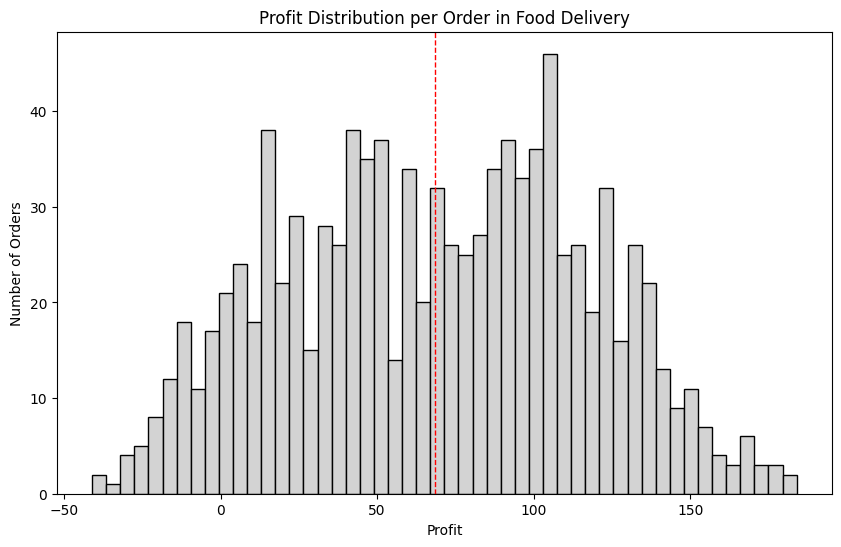

In [83]:
import matplotlib.pyplot as plt

# histogram of profits per order
plt.figure(figsize=(10, 6))
plt.hist(food_orders['Profit'], bins=50, color='lightgrey', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(food_orders['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

The histogram shows a wide distribution of profit per order, with a noticeable number of orders resulting in a loss (profits below 0). The red dashed line indicates the average profit, which is in the negative territory, highlighting the overall loss-making situation.



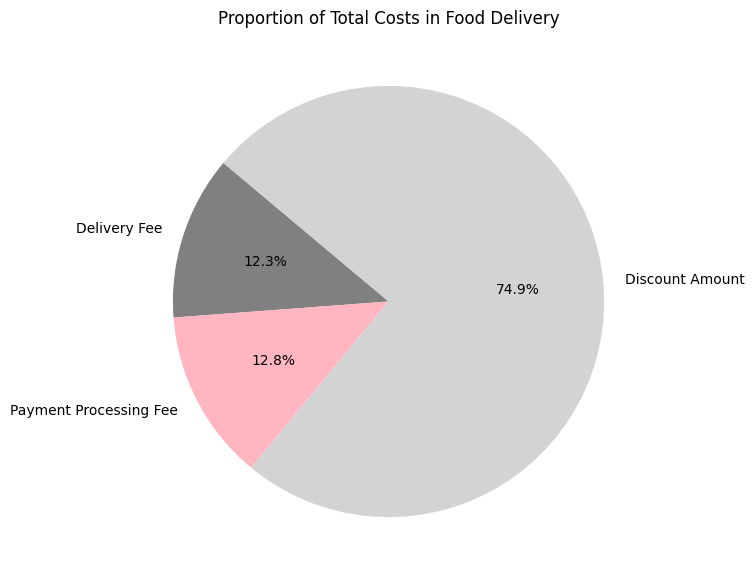

In [41]:
# pie chart for the proportion of total costs
costs_breakdown = food_orders[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 7))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['grey', 'lightpink', 'lightgrey'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

Discounts constitute a significant portion of the costs, suggesting that promotional strategies might be heavily impacting overall profitability.

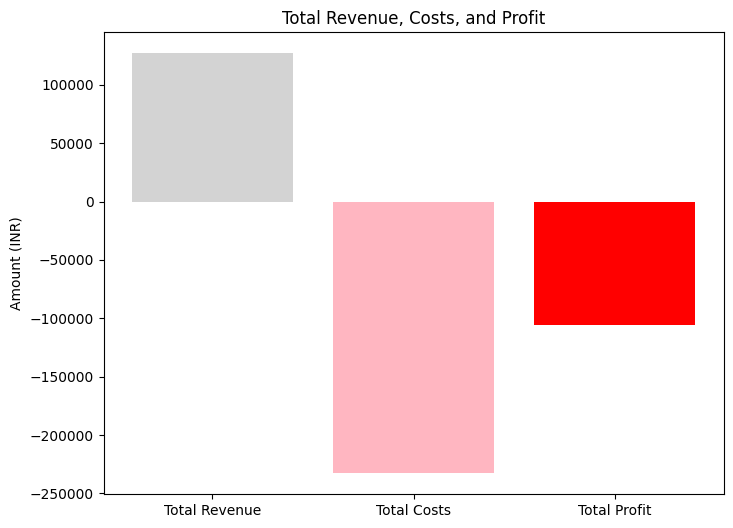

In [38]:
# bar chart for total revenue, costs, and profit
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_costs*-1, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['lightgrey', 'lightpink', 'red'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount (INR)')
plt.show()

# New Strategy for Profits
From the analysis so far we understood that the discounts on food orders are resulting in huge losses. Now, we need to find a new strategy for profitability. We need to find a sweet spot for offering discounts and charging commissions. To find a sweet spot for commission and discount percentages, we can analyze the characteristics of profitable orders more deeply. Specifically, we need to look for:

* A new average commission percentage based on profitable orders.
* A new average discount percentage for profitable orders, that could serve as a guideline for what level of discount still allows for profitability.

Given these new averages, we can suggest adjustments that might not only make individual orders profitable but also apply broadly across all orders to improve overall profitability. Let’s calculate:

* The average commission percentage for profitable orders.
* The average discount percentage for profitable orders.


In [39]:
# filter the dataset for profitable orders
profitable_orders = food_orders[food_orders['Profit'] > 0]
profitable_orders = profitable_orders.copy()  # Explicitly make a copy

# calculate the average commission percentage for profitable orders
profitable_orders['Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

# calculate the average discount percentage for profitable orders
profitable_orders['Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100

# calculate the new averages
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean().round(1)
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean().round(1)

print("Avg. Commision:", new_avg_commission_percentage, "%")
print("Avg. Discount:", new_avg_discount_percentage, "%")

Avg. Commision: 30.5 %
Avg. Discount: 5.9 %


Based on the analysis of profitable orders, we find a new set of averages that could represent a “sweet spot” for commission and discount percentages:

* New Average Commission Percentage: 30.51%
* New Average Discount Percentage: 5.87%

The average commission percentage for profitable orders is significantly higher than the overall average across all orders. It suggests that a higher commission rate on orders might be a key factor in achieving profitability. The average discount percentage for profitable orders is notably lower than the overall average, indicating that lower discounts might contribute to profitability without significantly deterring order volume.

Based on this analysis, a strategy that aims for a commission rate closer to 30% and a discount rate around 6% could potentially improve profitability across the board.



# Comparison of profitability
**Comparison of profitability using actual versus recommended discounts and commissions across all orders.**

* Calculate the profitability per order using the actual discounts and commissions already present in the dataset.
* Simulate profitability per order using the recommended discounts (6%) and commissions (30%) to see the potential impact on profitability.


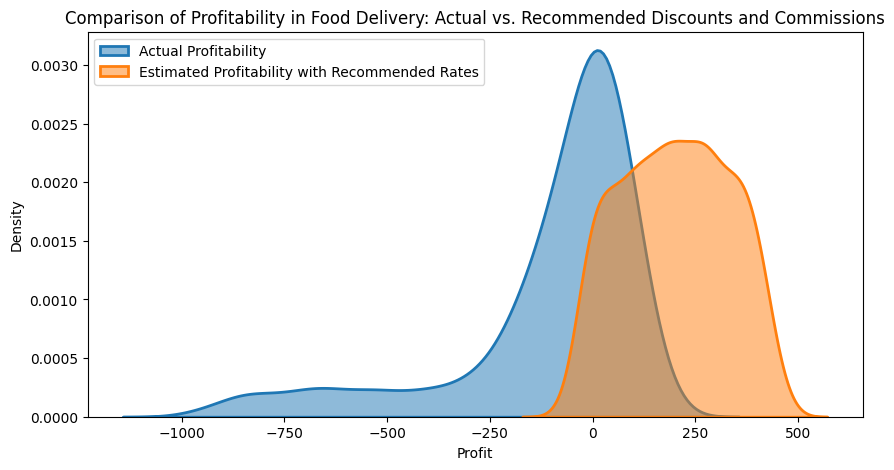

In [40]:
# simulate profitability with recommended discounts and commissions
recommended_commission_percentage = new_avg_commission_percentage
recommended_discount_percentage = new_avg_discount_percentage

# calculate the simulated commission fee and discount amount using recommended percentages
food_orders['Simulated Commission Fee'] = food_orders['Order Value'] * (recommended_commission_percentage / 100)
food_orders['Simulated Discount Amount'] = food_orders['Order Value'] * (recommended_discount_percentage / 100)

# recalculate total costs and profit with simulated values
food_orders['Simulated Total Costs'] = (food_orders['Delivery Fee'] +
                                        food_orders['Payment Processing Fee'] +
                                        food_orders['Simulated Discount Amount'])

food_orders['Simulated Profit'] = (food_orders['Simulated Commission Fee'] -
                                   food_orders['Simulated Total Costs'])

plt.figure(figsize=(10, 5))

# actual profitability
sns.kdeplot(food_orders['Profit'], label='Actual Profitability', fill=True, alpha=0.5, linewidth=2)

# simulated profitability
sns.kdeplot(food_orders['Simulated Profit'], label='Estimated Profitability with Recommended Rates', fill=True, alpha=0.5, linewidth=2)

plt.title('Comparison of Profitability in Food Delivery: Actual vs. Recommended Discounts and Commissions')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

The visualization compares the distribution of profitability per order using actual discounts and commissions versus the simulated scenario with recommended discounts (6%) and commissions (30%).

The actual profitability distribution shows a mix, with a significant portion of orders resulting in losses (profit < 0) and a broad spread of profit levels for orders. The simulated scenario suggests a shift towards higher profitability per order. The distribution is more skewed towards positive profit, indicating that the recommended adjustments could lead to a higher proportion of profitable orders.



# Conclusions
Food Delivery Cost and Profitability Analysis involves examining all the costs associated with delivering food orders, from direct expenses like delivery fees and packaging to indirect expenses like discounts offered to customers and commission fees paid by restaurants. By juxtaposing these costs against the revenue generated (primarily through order values and commission fees), the analysis aims to provide insights into how profitable the food delivery service is on a per-order basis.